# Градиентый спуск и линейные модели

## Аналитическое решение задачи разделения точек на плоскости

In [3]:
#подключаем необходимые библиотеки

%matplotlib inline

import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

Для начала нам нужно создать данные - два облака точек. В коде я использую константы: размер области, в которой строятся графики/рисуются точки, сигму - дисперсию нормального распределения, и количество точек в каждом из облаков.

In [ ]:
AXIS_RANGE = 10
SIGMA = 3
CLUSTER_SIZE = 1000

Функция make_two_clusters создает два облака точек размера CLUSTER_SIZE каждое, центр первого в точке (AXIS_RANGE/3, AXIS_RANGE/3), т.е. в верхней правой четверти, центр второго симметричен относительно точки начала координат. Координаты точек и метки кластеров построчно записываются в матрицы X и Y, сначала точки первого облака, затем второго.

In [4]:
def make_two_clusters(SIGMA, AXIS_RANGE, CLUSTER_SIZE):
    ones_column = np.ones((CLUSTER_SIZE, 1))
    clusterPlus = np.append(np.random.normal(AXIS_RANGE / 3, SIGMA, (CLUSTER_SIZE, 2)), ones_column, axis=1)
    clusterMinus = np.append(np.random.normal(-AXIS_RANGE / 3, SIGMA, (CLUSTER_SIZE, 2)), ones_column, axis=1)
    return np.append(clusterPlus, clusterMinus, axis=0), np.append(np.ones(CLUSTER_SIZE), -np.ones(CLUSTER_SIZE))

Функция draw_2d_points рисует точки на плоскости (преполагается, что сначала идут CLUSTER_SIZE точек первого облака, затем точки второго облака)

In [6]:
def draw_2d_points(X, CLUSTER_SIZE, SIGMA, AXIS_RANGE):
    plt.grid(True)
    plt.axis([-AXIS_RANGE, AXIS_RANGE, -AXIS_RANGE, AXIS_RANGE])
    plt.title(str(CLUSTER_SIZE) + ' points in each cluster')
    plt.scatter(X[:CLUSTER_SIZE, 0], X[:CLUSTER_SIZE, 1], c='r', s=30, alpha=0.7, edgecolors='none')
    plt.scatter(X[CLUSTER_SIZE:, 0], X[CLUSTER_SIZE:, 1], c='b', s=30, alpha=0.7, edgecolors='none')

Фукнция solve_least_squares возвращает вектор весов - аналитическое решение задачи минимизации метрики наименьших квадратов

In [9]:
def solve_least_squares(X, Y):
    trans_X = X.transpose()
    weights = np.dot(np.linalg.inv(np.dot(trans_X, X)), np.dot(trans_X, Y))
    return weights

Функция draw_splitter рисует разделяющую прямую (используются точки, "иксы" которых -AXIS_RANGE и AXIS_RANGE)

In [8]:
def draw_splitter(w, AXIS_RANGE, line_color, line_label=""):
    plt.plot([-AXIS_RANGE, AXIS_RANGE], [(AXIS_RANGE * w[1] + w[2])/w[0], (-AXIS_RANGE * w[1] + w[2])/w[0]],
             label=line_label, color=line_color, linestyle='--')

Теперь само тело программы

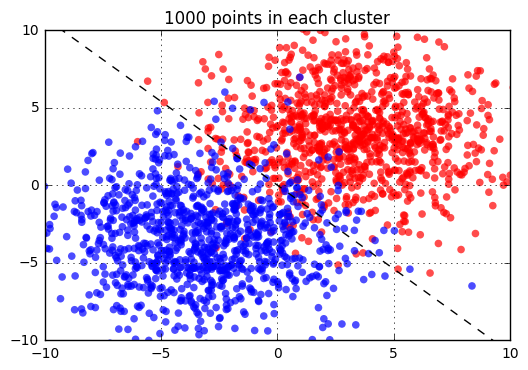

In [46]:
X, Y = make_two_clusters(SIGMA, AXIS_RANGE, CLUSTER_SIZE)
w = solve_least_squares(X, Y)

draw_splitter(w, AXIS_RANGE, 'k')
draw_2d_points(X, CLUSTER_SIZE, SIGMA, AXIS_RANGE)
plt.show()

Сложность метода складывается из сложности вычисления $w = (X^TX)^{-1}X^TY$.

Пусть разбиваемых точек $n$ и они имеют размерность $d$, тогда мы последовательно выполняем: транспонирование $X$ за $O(nd)$, умножение $X$ на $X^T$ имеет сложность $O(nd^2)$ (мы должны получить матрицу $d\times d$ ячеек, чтобы вычислить каждую ячейку мы должны скалярно умножить два $n$-мерных вектора), вычисление $(X^TX)^{-1}$ имеет сложность $O(d^3)$, умножение $X^TY$ за $O(nd)$ (заполняем $d$ ячеек скалярными произведениями $n$-мерных векторов) и итоговое умножение $(X^TX)^{-1}$ и $X^TY$ за $O(d^2)$. Итоговая сложность $O(nd^2 + d^3)$, или линейная от числа точек.

## Функции ошибок

Будем изображать следующие ошибки:

Эмперический риск 

$$[M(x, y_{true}) < 0]$$

Квадратичную ошибку

$$((wx_i+b) - y_i)^{2}$$

Ошибку из метода опорных векторов

$$\max(0, 1 - y_i\cdot(wx_i + b))$$

Логистическую ошибку

$$\ln(1 + \exp(-y_i\cdot(wx_i + b)))$$

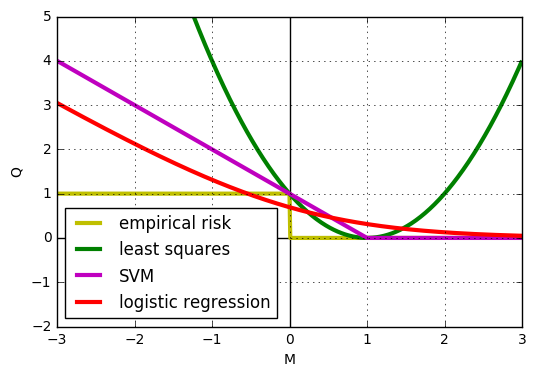

In [53]:
plt.grid(True)
plt.axhline(0, color="black")
plt.xlabel('M')
plt.axvline(0, color="black")
plt.ylabel('Q')

plt.axis([-3, 3, -2, 5])
z = np.arange(-3, 3, 0.01)

plt.plot(z, np.sign(np.sign(-z) + 1), 'y', label='empirical risk', linewidth=3)

plt.plot(z, (z - 1)**2, 'g', label='least squares', linewidth=3)

plt.plot(z, np.multiply(-z + 1, z < 1), 'm', label='SVM', linewidth=3)

plt.plot(z, np.log(np.exp(-z) + 1), 'r', label='logistic regression', linewidth=3)

plt.legend(loc='lower left')
plt.show()

## Максимизация правдоподобия

У нас есть некоторый неизвестный параметр w и череда независимых наблюдений $x_1, x_2\dots x_n$ случайных величин с одинаковым распределением, мы хотим найти максимально правдоподобное значение этого неизвестного параметра, при котором мы можем получить данную выборку.

В дискретном случае максимизация правдоподобия есть максимизация функции правдоподобия следующего вида:

$$f(X, w) = f_w(x_1)f_w(x_2)\dots f_w(x_n) = P_w(x_1 | y_1)P_w(x_2 | y_2)\dots P_w(x_2 | y_2) = $$


$$ = \frac{1}{1+\exp(−y_1(wx_1+b))} \frac{1}{1+\exp(−y_2(wx_2+b))} \dots \frac{1}{1 + \exp(−y_n(wx_n+b))}$$


(т.к. если $y_i = -1$, то $P_w(x_i | y_i) = 1 - P_w(x_i | 1) = 1 - \frac{1}{1 + \exp(-(wx_i+b))}  = \frac{1}{1 + \exp(wx_i+b)})$


Возьмем логарифм от этой функции - т.к. логарифм монотонно возрастающая функция, то у $t$ и $\ln(t)$ минимумы совпадают


$$\ln(f(X, w)) = \ln(\frac{1}{1+\exp(−y_1(wx_1+b))} \frac{1}{1+\exp(−y_2(wx_2+b))} \dots \frac{1}{1 + \exp(−y_n(wx_n+b))}) = $$


$$ =\ln(\frac{1}{1+\exp(−y_1(wx_1+b))}) + \ln(\frac{1}{1+\exp(−y_2(wx_2+b))}) + \dots + \ln(\frac{1}{1 + \exp(−y_n(wx_n+b))}) = $$


$$ = - (\ln(1+\exp(−y_1(wx_1+b))) + \ln(1+\exp(−y_2(wx_2+b))) + \dots + \ln(1 + \exp(−y_n(wx_n+b)))) = $$


$$ = -\sum_{x, y} \ln(1 + \exp(-y(wx + b)))$$

А максимизация этой функции есть минимизация функции $\sum_{x, y} \ln(1 + \exp(-y(wx + b)))$, ч.т.д.


## Градиентный спуск

Для испытания градиентного спуска я взял функцию $2\cdot(x - 5)^2 + (y - 10)^2$ с глобальным минимумом в точке $(5; 10)$.

In [38]:
def my_square_func(arg):
    return 2 * (arg[0] - 5)**2 + (arg[1] - 10)**2

Градиент этой функции равен $(4\cdot(x - 5); 2\cdot(y - 10))$

In [194]:
def my_square_grad(position):
    return np.array([4 * (position[0] - 5), 2 * (position[1] - 10)])

Первый блок кода изображает линии уровня.

В качестве начальной точки я взял $(-9; 1)$. Мой спуск останавливается, когда длина градиента становится меньше, чем $\epsilon = 10^{-4}$. Во время спуска промежуточные точки записываются в массив path для последующего вывода. Значение $\lambda = 0.1$

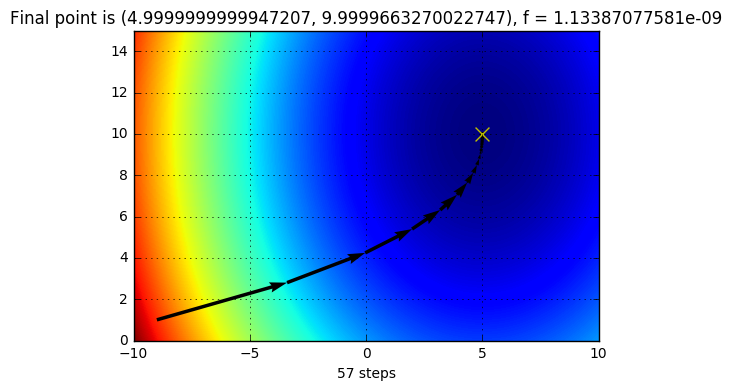

In [207]:
# Изображаем линии уровня
plt.grid(True)
plt.axis([-10, 10, 0, 15])
gridX = np.arange(-10, 11, 0.3)
gridY = np.arange(0, 16, 0.3)
gridX, gridY = np.meshgrid(gridX, gridY)
gridZ = 2 * (gridX - 5)**2 + (gridY - 10)**2
plt.contourf(gridX, gridY, gridZ, 1000)

# Инициализируем переменные и константы
EPS = 1e-4
LMBD = 1e-1

# Сам спуск
def base_grad_descent(start, count_grad, LMBD, EPS):
    currentPosition = np.array(start)
    grad = count_grad(currentPosition)
    path = np.array([currentPosition])

    while np.linalg.norm(grad) > EPS:
        grad = count_grad(currentPosition)
        currentPosition -=  LMBD * grad
        path = np.append(path, [currentPosition], axis=0)
    return path

# Изображение следа спуска
def draw_path(path, function=None, marker_shape, line_color, titlesOn = True):
    if titlesOn:
        plt.title('Final point is ' + str((path[-1, 0], path[-1, 1])) + ', f = ' + str(function(path[-1])))
        plt.xlabel(str(len(path)) + " steps")
    
    plt.quiver(path[:-1, 0], path[:-1, 1], path[1:, 0] - path[:-1, 0], path[1:, 1] - path[:-1, 1],
                                                        color=line_color, scale_units='xy', angles='xy', scale=1)
    plt.scatter(path[-1, 0], path[-1, 1], s=100, c='y', marker=marker_shape)
    return 0

draw_path(base_grad_descent([-9., 1.], my_square_grad, LMBD, EPS), my_square_func, 'x', 'k')

plt.show()

| λ | Количество шагов |
|--------|------------------|
| 1      | Расходится       |
| 0.1    | 56               |
| 0.01   | 600              |
| 0.001  | 6046             |
| 0.0001 | 60499            |

Данное значение $\lambda$ было подобрано экспериментально конкретно для запуска из этой точки. Если бы $\lambda$ была порядком выше - наш спуск бы "убегал" в бесконечность - большое значение градиента в стартовой точке индуцировало бы большой прыжок в область, где градиент еще больше и т.д.

При меньших значениях $\lambda$ схождение происходит на порядок медленнее.

## Функция Розенброка

Попробуем то же самое для функции Розенброка. Сначала изобразим небольшую окрестность около точки минимума $(1; 1)$

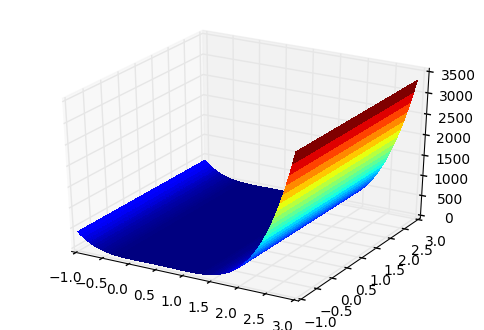

In [54]:
fig = plt.figure()
ax = fig.gca(projection='3d')

gridX = np.arange(-1, 3, 0.05)
gridY = np.arange(-1, 3, 0.05)
gridX, gridY = np.meshgrid(gridX, gridY)
gridZ = np.square(-gridX + 1) + 100 * np.square((gridX - np.multiply(gridX, gridX)))

surf = ax.plot_surface(gridX, gridY, gridZ, rstride=1, cstride=1, cmap=cm.jet,
                       linewidth=0, antialiased=False)
plt.show()

Возьмем для старта точку $(5; 5)$.
Первая проблема - градиент в этой точке очень большой - его длина около 40000 (а если еще дальше от пологой зоны - на порядки больше), но при этом вблизи точки минимума $(1; 1)$ функция очень пологая - нам не подойдет обыквенный спуск с постоянным значением лямбды или ее уменьшением в соответствии с расписанием - нам нужно укорачивать слишком большой градиент, чтобы не убежать на бесконечность, для этого будем нормирование градиента.

Используя нормирование градиента, если его длина больше 1, и лямбду равную $10^{-3}$ мы всего за 37000 шагов доходим до минимума (до точки, где градиент короче $\epsilon = 10^{-4}$; кстати, при больших значениях $\lambda$ мы не останавливаемся - все-таки градиент около точки максимума не такой маленький и мы не попадаем в точку, где он меньше $\epsilon$, та же проблема и у других стандартных условиях останова, поэтому же мы нормируем только большие значения градиента)

Объяснение такому большому числу шагов есть - градиент быстро заносит нас в очень пологую зону, в которой мы не напрямую приближаемся к точке минимума, а идем зиг-загами, т.к. форма этой пологой зоны не прямая или кривая, а гладкая изогнутая линия, а мы все время прыгаем то на один ее край, то на другой.

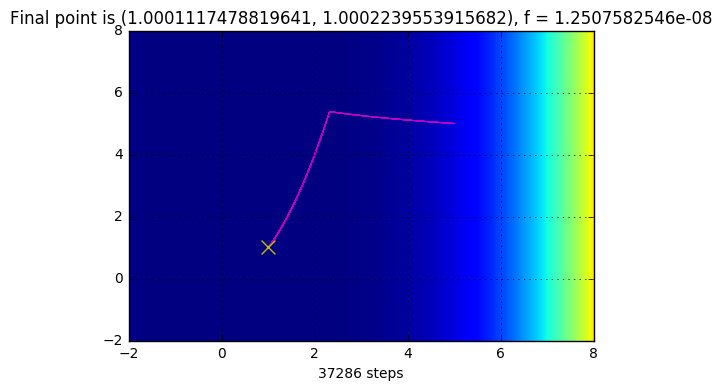

In [206]:
def Rosenbrock_function(arg):
    x = arg[0]
    y = arg[1]
    return (1-x)**2+100*(y-x**2)**2


def Rosenbrock_grad(position):
    x = position[0]
    y = position[1]
    return np.array([2*(x-1)-400*x*(y-x**2), 200*(y-x**2)])

# линии уровня
plt.grid(True)
plt.axis([-2, 8, -2, 8])
gridX = np.arange(-2, 9, 0.3)
gridY = np.arange(-2, 9, 0.3)
gridX, gridY = np.meshgrid(gridX, gridY)
gridZ = np.square(-gridX + 1) + 100 * np.square((gridX - np.multiply(gridX, gridX)))
plt.contourf(gridX, gridY, gridZ, 1000)


EPS = 1e-4
LMBD = 1e-3
currentPosition = np.array([5., 5.])
grad = Rosenbrock_grad(currentPosition)
path = np.array([currentPosition])
gradPrevious = np.zeros((2))

#Градиент с нормированием
while np.linalg.norm(grad) > EPS:
    gradPrevious = np.copy(grad)
    grad = Rosenbrock_grad(currentPosition)
    if np.linalg.norm(grad) > 1:
        grad /= np.linalg.norm(grad)
    currentPosition -= LMBD * grad
    path = np.append(path, [currentPosition], axis=0)

draw_path(path, Rosenbrock_function, 'x', 'm')

plt.show()

## Наискорейший спуск

Для начала напишем функцию подсчета градиента, сгенерируем данные и зададим погрешность

In [414]:
AXIS_RANGE = 10
SIGMA = 3
CLUSTER_SIZE = 500
    
def count_least_squares_grad(w, X, Y):
    Z = X.dot(w) - Y
    return np.divide(np.array([np.sum(Z * X[:, 0]), np.sum(Z * X[:, 1]), np.sum(Z)]), len(Y))


X, Y = make_two_clusters(SIGMA, AXIS_RANGE, CLUSTER_SIZE)

Для обычного градиентного спуска я выбрал $\lambda = 0.05$, сколько раз тестировал - сходится достаточно быстро (см. таблицу для одного из тестов)

| Лямбда | Количество шагов |
|--------|------------------|
| 0.1    | Расходится       |
| 0.05   | 14               |
| 0.01   | 18               |
| 0.001  | 195              |
| 0.0001 | 1964             |

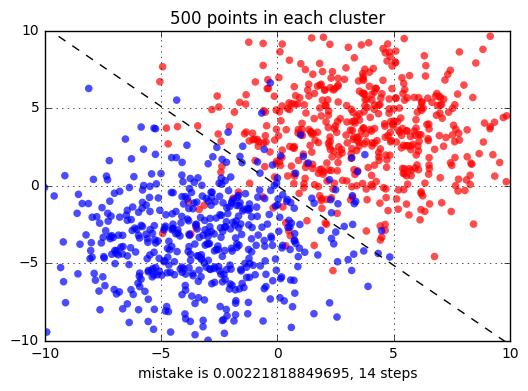

In [424]:
# Простой градиентный спуск
LMBD = 0.05
w = np.zeros(3)
grad = count_least_squares_grad(w, X, Y)
stepCounter = 0
mistakeTrack = []
EPS = 1e-2

while np.linalg.norm(grad) > EPS:
    stepCounter += 1
    grad = count_least_squares_grad(w, X, Y)
    mistakeTrack.append(np.sum(np.square(X.dot(w) - Y)) / len(Y))
    w -= LMBD*grad

draw_2d_points(X, CLUSTER_SIZE, SIGMA, AXIS_RANGE)
draw_splitter(w, AXIS_RANGE, 'k')

mistake = np.linalg.norm(solve_least_squares(X, Y) - w)
plt.xlabel("mistake is " + str(mistake) + ", " + str(stepCounter) + " steps")

plt.show()

Изображаем график зависимости ошибки от шага

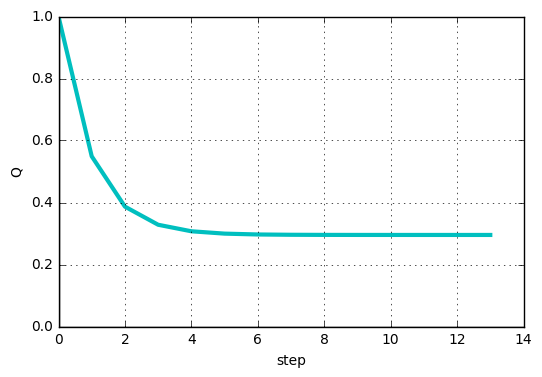

In [416]:
plt.grid(True)
plt.axhline(0, color="black")
plt.xlabel('step')
plt.axvline(0, color="black")
plt.ylabel('Q')
plt.plot(np.array(range(len(mistakeTrack))), mistakeTrack, 'c', linewidth=3)
plt.show()

Теперь проверим наискорейший спуск. Для квадратичной метрики нам не нужно подбирать размер шага с помощью деления отрезка или каких-то других способов - если выписать задачу линейной оптимизации по подбиаемому параметру, она будет иметь вид квадратного уравнения, ее минимум - в вершине, координаты которой выражаются вырвиглазной формулой (в коде - вычисление linearCoefficient)

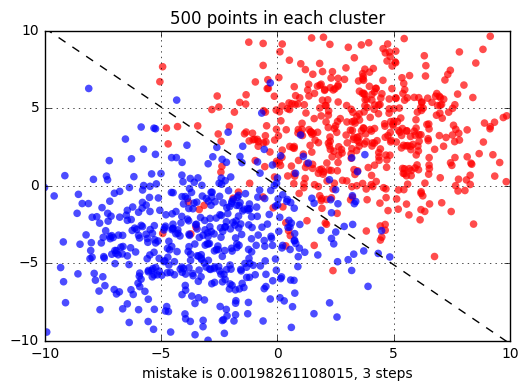

In [417]:
# Наискорейший спуск
w = np.zeros(3)
grad = count_least_squares_grad(w, X, Y)
stepCounter = 0

while np.linalg.norm(grad) > EPS:
    grad = count_least_squares_grad(w, X, Y)
    linearCoefficient = np.sum(np.dot(np.dot(X, grad.transpose()), np.dot(X, w.transpose()) - Y)) / np.sum(np.square(np.dot(X, grad.transpose())))
    w -= grad * linearCoefficient
    stepCounter += 1

draw_2d_points(X, CLUSTER_SIZE, SIGMA, AXIS_RANGE)
draw_splitter(w, AXIS_RANGE, 'k')

mistake = np.linalg.norm(solve_least_squares(X, Y) - w)
plt.xlabel("mistake is " + str(mistake) + ", " + str(stepCounter) + " steps")

plt.show()

На тех же данных обычный спуск делает 14 шагов, наискорейший - 3. Благодаря тому, что для нашей метрики существует явное решение задачи линейной оптимизации, с каждым шагом мы эффективно приближаемся к точке минимума, когда как обычный спуск после 3 шага хотя почти и не изменяется, но условие остановки не выполняется

## Стохастический градиентный спуск

Для начала считываем данные о рукописных цифрах и оставляем только те, которые касаются 0 и 1. Для единиц мы оставляем метку 1, а нулям присваиваем метку -1.

In [4]:
def get_data():
    data = np.genfromtxt('train.csv', delimiter=',')
    data = data[1:]
    data = data[data[:, 0] <= 1]
    data[:, 0] = (data[:, 0] - 0.5) * 2
    data = np.append(data, np.ones((data.shape[0], 1)), axis=1)
    return data

data = get_data()

Делим наши данные на обучающую и тестовую выборки, т.к. при обучении на всем дата-сете данные успешно разделяются и неправильно определенных цифр нет.

Для тестовой выборки я взял 2500 из 8816 элементов. Чтобы число шагов сильнее кореллировало с размером батча - установим небольшие значения $\epsilon = 10^{-5}$ и $\lambda = 10^{-4}$. Условие остановки - разность значений функций между прогонами (полными проходами по выборке) не больше $\epsilon$.

Между прогонами я перемешиваю выборку, чтобы элементы из конца, не попавшие в батч, попали в него на следующем прогоне.

In [5]:
def logistic_grad(w, train_set):
    X = train_set[:, 1:]
    Y = train_set[:, 0]
    temp = np.exp(np.multiply(-Y, X.dot(w)))
    temp = np.divide(temp, temp + 1)
    temp = np.multiply(temp, -Y)
    return np.divide(temp.dot(X), len(train_set))

def logistic_loss(w, train_set):
    X = train_set[:, 1:]
    Y = train_set[:, 0]
    temp = np.log(np.exp(np.multiply(-Y, X.dot(w))) + 1)
    return np.sum(temp) / len(train_set)

def kaggle_descent(train_set, BUTCH_SIZE, LMBD, EPS):
    w = np.zeros(785)
    step = 0
    previous_w = w + EPS;
    while abs(logistic_loss(w, train_set) - logistic_loss(previous_w, train_set)) > EPS:
        np.random.shuffle(train_set)
        temp_position = 0
        previous_w = np.copy(w)
        step += 1
        while temp_position + BUTCH_SIZE < len(train_set):
            grad = logistic_grad(w, train_set[temp_position : temp_position + BUTCH_SIZE])
            w -= LMBD * grad
            temp_position += BUTCH_SIZE
    return w, step

def count_mistakes(w, test_set):
    guessed = 0
    for i in range(len(test_set)):
        t = test_set[i, 1:].dot(w)
        if t >= 0 and test_set[i, 0] == 1 or t < 0 and test_set[i, 0] == -1:
            guessed += 1
    return len(test_set) - guessed


TEST_SET_SIZE = 2500
train_set, test_set = data[:-TEST_SET_SIZE], data[-TEST_SET_SIZE:]
BUTCH_SIZE = 100
LMBD = 1e-4
EPS = 1e-5

w, stepCounter = kaggle_descent(train_set, BUTCH_SIZE, LMBD, EPS)
mistakeCounter = count_mistakes(w, test_set)
print("butch size is ", BUTCH_SIZE, ", ", mistakeCounter, "/", len(test_set), " mistakes, ", stepCounter, " steps")

butch size is  100 ,  3 / 2500  mistakes,  15  steps


### Зависимость количества прогонов и числа ошибок от размера батча
|Размер батча|Ошибок на тестовой выборке|Количество прогонов
|----|-----|----|
|1  |  2  |  7  |
|2  |  3  |  4  |
|4  |  3  |  7  |
|8  |  4  |  6  |
|16  |  2  |  5  |
|32  |  3  |  7  |
|64  |  2  |  10  |
|128  |  2  |  16  |
|256  |  2  |  31  |
|512  |  2  |  47  |
|1024  |  2  |  61  |
|2048  |  2  |  87  |

Как мы видим, число ошибок зависит не от размера батча, а скорее от условия остановки - числа $\epsilon$, т.к. именно оно отвечает за качество разбиения. Зато от этого же числа $\epsilon$ сильно зависит количество прогонов, за которые данная точность достигается, 

## Сохранение импульса

Опробуем на функции $10x^2 + y^2$ метод, в котором каждый шаг спуска зависит не только от градиента, но и от предыдущего шага

In [231]:
def my_func_impulse(arg):
    return 10 * arg[0]**2 + arg[1]**2


def grad_impulse(position):
    return np.array([20 * position[0], 2 * position[1]])

def impulse_descent(start, count_grad, GAMMA, LMBD, EPS):
    currentPosition = np.array(start)
    grad = count_grad(currentPosition)
    path = np.array([currentPosition])
    step = np.zeros(2)

    while np.linalg.norm(grad) > EPS:
        grad = count_grad(currentPosition)
        step = GAMMA * step + LMBD * grad
        currentPosition -=  step
        path = np.append(path, [currentPosition], axis=0)
    return path

Запустим наш спуск с разными параметрами $\gamma$ из точки $(8; 10)$

Black is for simple descent, 759 steps
White is for γ = 0.4, 450 steps
Cyan is for γ = 0.7, 209 steps
Red is for γ = 0.9, 134 steps


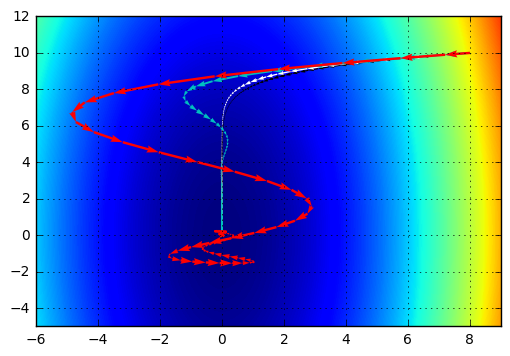

In [425]:
plt.grid(True)
plt.axis([-6, 9, -5, 12])
gridX = np.arange(-6, 10, 0.2)
gridY = np.arange(-5, 13, 0.2)
gridX, gridY = np.meshgrid(gridX, gridY)
gridZ = 10 * (gridX)**2 + (gridY)**2
plt.contourf(gridX, gridY, gridZ, 1000)


EPS = 1e-2
LMBD = 5e-3

currentPath = impulse_descent([8., 10.], grad_impulse, 0, LMBD, EPS)
draw_path(currentPath, None, None, 'k', False)
print("Black is for simple descent,", len(currentPath), "steps")

currentPath = impulse_descent([8., 10.], grad_impulse, 0.4, LMBD, EPS)
draw_path(currentPath, None, None, 'w', False)
print("White is for γ = 0.4,", len(currentPath), "steps")

currentPath = impulse_descent([8., 10.], grad_impulse, 0.7, LMBD, EPS)
draw_path(currentPath, None, None, 'c', False)
print("Cyan is for γ = 0.7,", len(currentPath), "steps")

currentPath = impulse_descent([8., 10.], grad_impulse, 0.9, LMBD, EPS)
draw_path(currentPath, None, None, 'r', False)
print("Red is for γ = 0.9,", len(currentPath), "steps")

plt.show()

При $\gamma = 0.4$ наш спуск с сохранением импульса слабо отличим от обыкновенного, но заметно быстрее, при $\gamma$ близкое к 1 спуск расходится, но чем больше $\gamma$, тем быстрее мы двигаемся, тем меньше шагов, поэтому желательно выбрать $\gamma$ по-больше, но из тех, при которых спуск сходится, это гарантирует нам наименьшее число шагов

## Градиент Нестерова

In [219]:
def nesteroff_descent(start, count_grad, GAMMA, LMBD, EPS):
    currentPosition = start
    grad = count_grad(currentPosition)
    path = np.array([currentPosition])
    step = np.zeros(2)
    while np.linalg.norm(grad) > EPS:
        grad = count_grad(currentPosition - step)
        step = GAMMA * step + LMBD * grad
        currentPosition -=  step
        path = np.append(path, [currentPosition], axis=0)
    return path

Т.к. предложенные методы не приспособлены для использования нормирования, речь идет о второй проблеме функции Розенброка - сильной пологости, поэтому будем запускать оба спуска вблизи пологой области

Red is for impulse descent,  4347 steps
Black is for Nesterov descent,  4561 steps


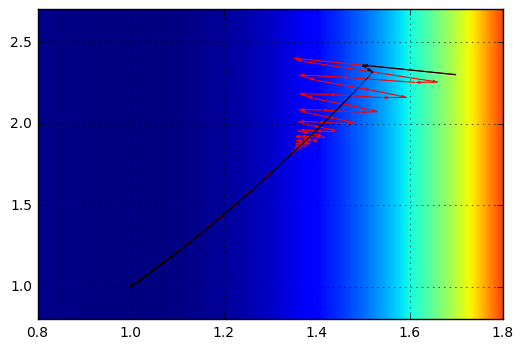

In [237]:
plt.grid(True)
plt.axis([0.8, 1.8, 0.8, 2.7])
gridX = np.arange(0.8, 1.9, 0.05)
gridY = np.arange(0.8, 2.8, 0.05)
gridX, gridY = np.meshgrid(gridX, gridY)
gridZ = np.square(-gridX + 1) + 100 * np.square((gridX - np.multiply(gridX, gridX)))
plt.contourf(gridX, gridY, gridZ, 1000)

EPS = 1e-4
LMBD = 5e-4

currentPath = impulse_descent([1.7, 2.3], Rosenbrock_grad, 0.9, LMBD, EPS)
draw_path(currentPath, None, None, 'r', False)
print('Red is for impulse descent, ', len(currentPath), 'steps')

currentPath = nesteroff_descent([1.7, 2.3], Rosenbrock_grad, 0.9, LMBD, EPS)
draw_path(currentPath, None, None, 'k', False)
print('Black is for Nesterov descent, ', len(currentPath), 'steps')

plt.show()

Как мы видим, скорость сходимости у обоих методов похожая, но градиент Нестерова практически не идет зиг-загами, т.к. ему не нужно "перепрыгивать" на другую сторону от линии, вдоль которой функция пологая, чтобы понять, что придется прыгать обратно - он уже понимает, примерно в каком направлении должно происходить движение

## Adagrad

Будем хранить только диагональ матрицы G в виде вектора, тогда градиент перед домножением на лямбду будет просто покоординатно делиться на квадратный корень из diag_G

In [426]:
def make_g(grad):
    g_row = np.array([grad])
    g_col = np.array(g_row.transpose())
    return g_col.dot(g_row)

def kaggle_adagrad_descent(train_set, BUTCH_SIZE, LMBD, EPS):
    w = np.zeros(785)
    step = 0
    previous_w = w + EPS;
    diag_G = np.zeros(785)
    while abs(logistic_loss(w, train_set) - logistic_loss(previous_w, train_set)) > EPS:
        np.random.shuffle(train_set)
        temp_position = 0
        previous_w = np.copy(w)
        step += 1
        #print(diag_G)
        while temp_position + BUTCH_SIZE < len(train_set):
            grad = logistic_grad(w, train_set[temp_position : temp_position + BUTCH_SIZE])
            diag_G += np.square(grad)
            grad = np.divide(grad, np.sqrt(diag_G) + EPS)
            w -= LMBD * grad
            
            temp_position += BUTCH_SIZE
    return w, step

TEST_SET_SIZE = 2500
train_set, test_set = data[:-TEST_SET_SIZE], data[-TEST_SET_SIZE:]
BUTCH_SIZE = 100
LMBD = 1e-4
EPS = 1e-5
print("Butch size is ", BUTCH_SIZE)

w1, stepCounter1 = kaggle_adagrad_descent(train_set, BUTCH_SIZE, LMBD, EPS)
mistakeCounter1 = count_mistakes(w1, test_set)
print( "Adagrad:           ", mistakeCounter1, "/", len(test_set), " mistakes, ", stepCounter1, " steps")

w2, stepCounter2 = kaggle_descent(train_set, BUTCH_SIZE, LMBD, EPS)
mistakeCounter2 = count_mistakes(w2, test_set)
print( "Stochastic descent: ", mistakeCounter2, "/", len(test_set), " mistakes, ", stepCounter2, " steps")

Butch size is  100
Adagrad:            2 / 2500  mistakes,  89  steps
Stochastic descent:  2 / 2500  mistakes,  16  steps


Как мы видим, Адаград сходится медленнее при таких же значениях $\lambda$ и $\epsilon$, т.к. в целом элементы матрицы G становятся достаточно большими, спуск для неразреженных параметров, конечно, замедляется больше, но и для разреженных он замедляется прилично(скорее всего это из-за начального приближения - т.к. поначалу градиент любого признака достаточно большой, т.к. мы далеки от идеального положения, но простого решения этой проблемы нет), поэтому для сравнительного тестирования мы увеличим $\lambda$ для Адаграда на два порядка - но сравнение все равно будет достаточно честным: при данных значениях оба алгоритма сходятся на любом размере батча, но при увеличении $\lambda$ на один порядок оба перестают сходиться(для малых размеров батча) 

Как мы говорили ранее, качество зависит скорее от самих данных, случайности (как перемешаются данные между прогонами) и $\epsilon$, чем от размера батча, поэтому сравниваем скорость сходимости

In [323]:
TEST_SET_SIZE = 2500
train_set, test_set = data[:-TEST_SET_SIZE], data[-TEST_SET_SIZE:]

LMBD = 1e-4
EPS = 1e-5

BUTCH_SIZE = 1

butchSizes = []
adagradPlot = []
stochasticPlot = []
testQuantity = 5

while BUTCH_SIZE < 5000:
    adagradSteps = 0
    stochasticSteps = 0
    for i in range(testQuantity):
        w1, stepCounter1 = kaggle_adagrad_descent(train_set, BUTCH_SIZE, 100 * LMBD, EPS)
        adagradSteps += stepCounter1
        
        w2, stepCounter2 = kaggle_descent(train_set, BUTCH_SIZE, LMBD, EPS)
        stochasticSteps += stepCounter2
        
    butchSizes.append(BUTCH_SIZE)
    adagradPlot.append(adagradSteps / testQuantity)
    stochasticPlot.append(stochasticSteps / testQuantity)
    BUTCH_SIZE *= 2

Нарисуем графики: по x отложим логарифм размера батча (степень двойки), по y - количество шагов.

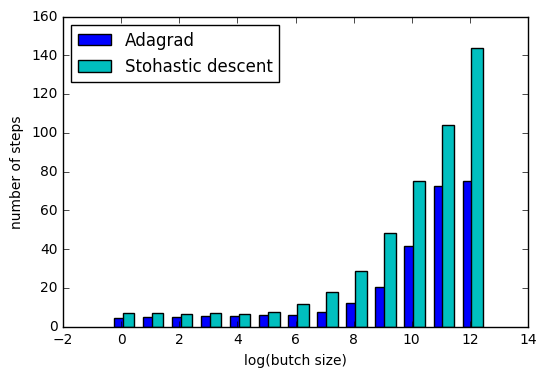

In [332]:
plt.bar(np.array(range(13)) - 0.25, adagradPlot, label='Adagrad', width=0.4)
plt.bar(np.array(range(13)) + 0.25, stochasticPlot, color='c', label='Stochastic descent', align='center', width=0.4)
plt.xlabel("log(butch size)")
plt.ylabel("number of steps")
plt.legend(loc='upper left')

plt.show()

Видно, что при небольших размерах батча количество шагов примерно одинаковое, а при больших Адаград обгоняет обыкновенный стохастический градиентный спуск

## RMSProp

Немного модифицировав Адаград, получим RMSprop и протестируем с размером батча 2000 - примерно при таких размерах наиболее видна разница между обыкновенным стохастическим градиентом и Адагардом

In [325]:
def kaggle_RMSprop(train_set, BUTCH_SIZE, GAMMA, LMBD, EPS):
    w = np.zeros(785)
    step = 0
    previous_w = w + EPS;
    diag_G = np.zeros(785)
    while abs(logistic_loss(w, train_set) - logistic_loss(previous_w, train_set)) > EPS:
        np.random.shuffle(train_set)
        temp_position = 0
        previous_w = np.copy(w)
        step += 1
        while temp_position + BUTCH_SIZE < len(train_set):
            grad = logistic_grad(w, train_set[temp_position : temp_position + BUTCH_SIZE])
            diag_G = GAMMA * diag_G + (1 - GAMMA) * np.square(grad)
            grad = np.divide(grad, np.sqrt(diag_G) + EPS)
            w -= LMBD * grad
            
            temp_position += BUTCH_SIZE
    return w, step

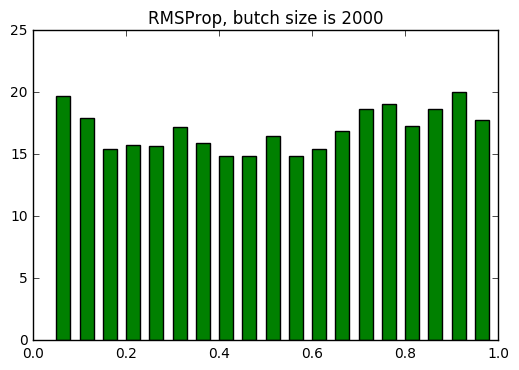

In [428]:
LMBD = 1e-2
EPS = 1e-5

BUTCH_SIZE = 2000
testQuantity = 10
averageSteps = []
gammas = np.arange(0.05, 0.96, 0.05)
for GAMMA in gammas:
    w, stepCounter = kaggle_RMSprop(train_set, BUTCH_SIZE, GAMMA, LMBD, EPS)
    mistakeCounter = count_mistakes(w, test_set)
    currentAverageSteps = 0
    for i in range(testQuantity) :
        w, stepCounter = kaggle_RMSprop(train_set, BUTCH_SIZE, GAMMA, LMBD, EPS)
        currentAverageSteps += stepCounter / testQuantity
    averageSteps.append(currentAverageSteps)

plt.bar(np.array(gammas), averageSteps, color='g', width=0.03)
plt.title("RMSProp, butch size is " + str(BUTCH_SIZE))
plt.show()

На нашем размере батча RMSprop делает намного меньше шагов, чем предыдущие алгоритмы. Можно объяснить это тем, что самый большой скачок значений G получается на самом первом шаге - когда мы стартуем с $w = (0; ... 0)$, Адаград никак не нивелирует эти почти ниоткуда взявшиеся числа, а RMSProp со временем сводит это начальное приближение на ноль.

Что касается оптимальных параметров - на нашей задаче никакого сильно хорошего значения нет, но теоретически оптимальное значение в районе 0.9

## Adam

Комбинируя предыдущий алгоритм и метод сохранения импульса, получаем алгоритм Adam. Дополнительные коэффициенты взяты из википедии (домножение на каждом шаге на $\frac{1}{1-\gamma^t}$)

$\gamma_1$ отвечает за диагональнь матрицы G, $\gamma_2$ за сохранение импульса

In [369]:
def kaggle_adam(train_set, BUTCH_SIZE, GAMMA1, GAMMA2, LMBD, EPS):
    w = np.zeros(train_set.shape[1] - 1)
    momentum = np.copy(w)
    step = 0
    previous_w = w + EPS;
    diag_G = np.copy(w)
    while abs(logistic_loss(w, train_set) - logistic_loss(previous_w, train_set)) > EPS:
        np.random.shuffle(train_set)
        temp_position = 0
        previous_w = np.copy(w)
        gamma1_t = GAMMA1
        gamma2_t = GAMMA2
        step += 1
        while temp_position + BUTCH_SIZE < len(train_set):
            grad = logistic_grad(w, train_set[temp_position : temp_position + BUTCH_SIZE])
            diag_G = GAMMA1 * diag_G + (1 - GAMMA1) * np.square(grad)
            diag_G_s = diag_G / (1 - gamma1_t)
            
            momentum = GAMMA2 * momentum + (1 - GAMMA2) * grad
            momentum_s = momentum / (1 - gamma2_t)
            
            grad = np.divide(momentum_s, np.sqrt(diag_G_s) + EPS)
            w -= LMBD * grad
            
            gamma1_t *= GAMMA1
            gamma2_t *= GAMMA2
            temp_position += BUTCH_SIZE
    return w, step

Встает вопрос об оптимальных значениях параметров, попробуем немного их поварьировать

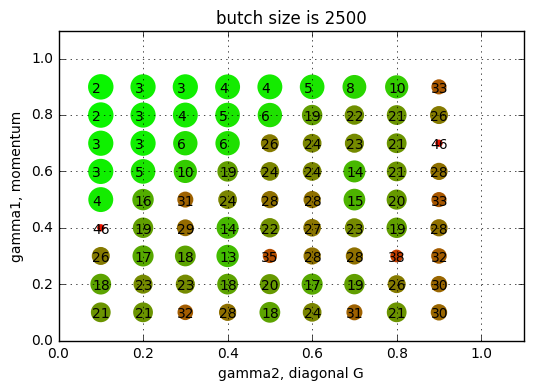

In [378]:
# Отключаем неитересные надписи
import warnings
warnings.filterwarnings('ignore')

BUTCH_SIZE = 2500
LMBD = 1e-2
EPS = 1e-5

#для лучшей раскраски этот параметр должен быть немногим больше максимального числа прогонов спуска
MAX_STEPS = 50

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 1.1), ylim=(0, 1.1))
plt.ylabel("gamma1, momentum")
plt.xlabel("gamma2, diagonal G")
plt.grid(True)
plt.title("butch size is " + str(BUTCH_SIZE))

for GAMMA1 in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9):
    for GAMMA2 in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9):
        w, stepCounter = kaggle_adam(train_set, BUTCH_SIZE, GAMMA1, GAMMA2, LMBD, EPS)
        RGBColor = (stepCounter / MAX_STEPS, 1. - (stepCounter / MAX_STEPS), 0.)
        plt.scatter(GAMMA1, GAMMA2, c=RGBColor, edgecolors='none', s=(7 * (MAX_STEPS - stepCounter)))
        ax.annotate(str(stepCounter), xy=(GAMMA1 - 0.02, GAMMA2 - 0.02))
plt.show()

Чем большее и зеленее круг - тем меньше прогонов делает спуск до того, как сойтись (в кружках число прогонов). Подобное распределение цветов кружков наблюдается и для других размеров батча. Сенсации не случилось - для нашей задачи оптимальное значение лямбды в методе с моментами около 1, а оптимальное значение лямбды в методе RMSProp - около нуля

В комбинации методов оптимальные значения имеют тот же характер

## Adadelta

Adadelta является модификацией adagrad'а, в котором коэффициент перед градиентом уменьшается постоянно (там у нас сумма квадратов, накапливающаяся с каждым шагом) и обучение сильно замедляется, Ададельта учитывает только несколько последних шагов (зависит от $\gamma$)

In [12]:
def kaggle_adadelta(train_set, BUTCH_SIZE, GAMMA, EPS, EPS2):
    w = np.zeros(train_set.shape[1] - 1)
    step = 0
    previous_w = w + EPS;
    e_G = 0
    e_dw = 0
    while abs(logistic_loss(w, train_set) - logistic_loss(previous_w, train_set)) > EPS:
        np.random.shuffle(train_set)
        temp_position = 0
        previous_w = np.copy(w)
        step += 1
        while temp_position + BUTCH_SIZE < len(train_set):
            grad = logistic_grad(w, train_set)
            e_G = GAMMA * e_G + (1 - GAMMA) * np.sum(grad)
            dw = np.sqrt(e_dw + EPS2) / np.sqrt(e_G) * grad
            e_dw = GAMMA * e_dw + (1 - GAMMA) *np.sum(np.square(dw))
            w -= dw
            temp_position += BUTCH_SIZE
    return w, step
TEST_SET_SIZE = 2500
train_set, test_set = data[:-TEST_SET_SIZE], data[-TEST_SET_SIZE:]
BUTCH_SIZE = 2000
EPS = 1e-5
w, step = kaggle_adadelta(train_set, BUTCH_SIZE, 0.99, EPS, 1e-6)
mistakeCounter = count_mistakes(w, test_set)
print( "Adadelta: ", mistakeCounter, "/", len(test_set), " mistakes, ", stepCounter, " steps")

Adadelta:  2 / 2500  mistakes,  15  steps


Хороший результат, на уровне с RMSProp